# Structure-function relation

In this notebook we analyze data from the paper "Cortical cell assemblies and their underlying connectivity: An in silico study" by Ecker et al., 2024. PLOS Comp. Biol.

Specifically, we analyze one aspect of the structure-function relation, demonstrating that the participation is connectivity motifs called "directed simplices" structures the spiking correlation of pairs of neurons.

The data we analyze can be found [on Zenodo](https://zenodo.org/records/8052722), deposited by the authors ("assemblies.h5" is the relevant file). However, the file is rather large and contains data that are not relevant for this notebook. So I created a stripped-down version that is available under the following [link](https://openbraininstitute-my.sharepoint.com/:u:/g/personal/michael_reimann_openbraininstitute_org/ETMQErJmt5dJqOiLEluGxdsBPwPTXG5IVRNCNb0RR-ftyQ?e=LoQdSI).

### Data contents:
In the publication, a biophysically-detailed model of 210000 neurons was simulated for several minutes while repeatedly stimulating it through thalamic input fibers.

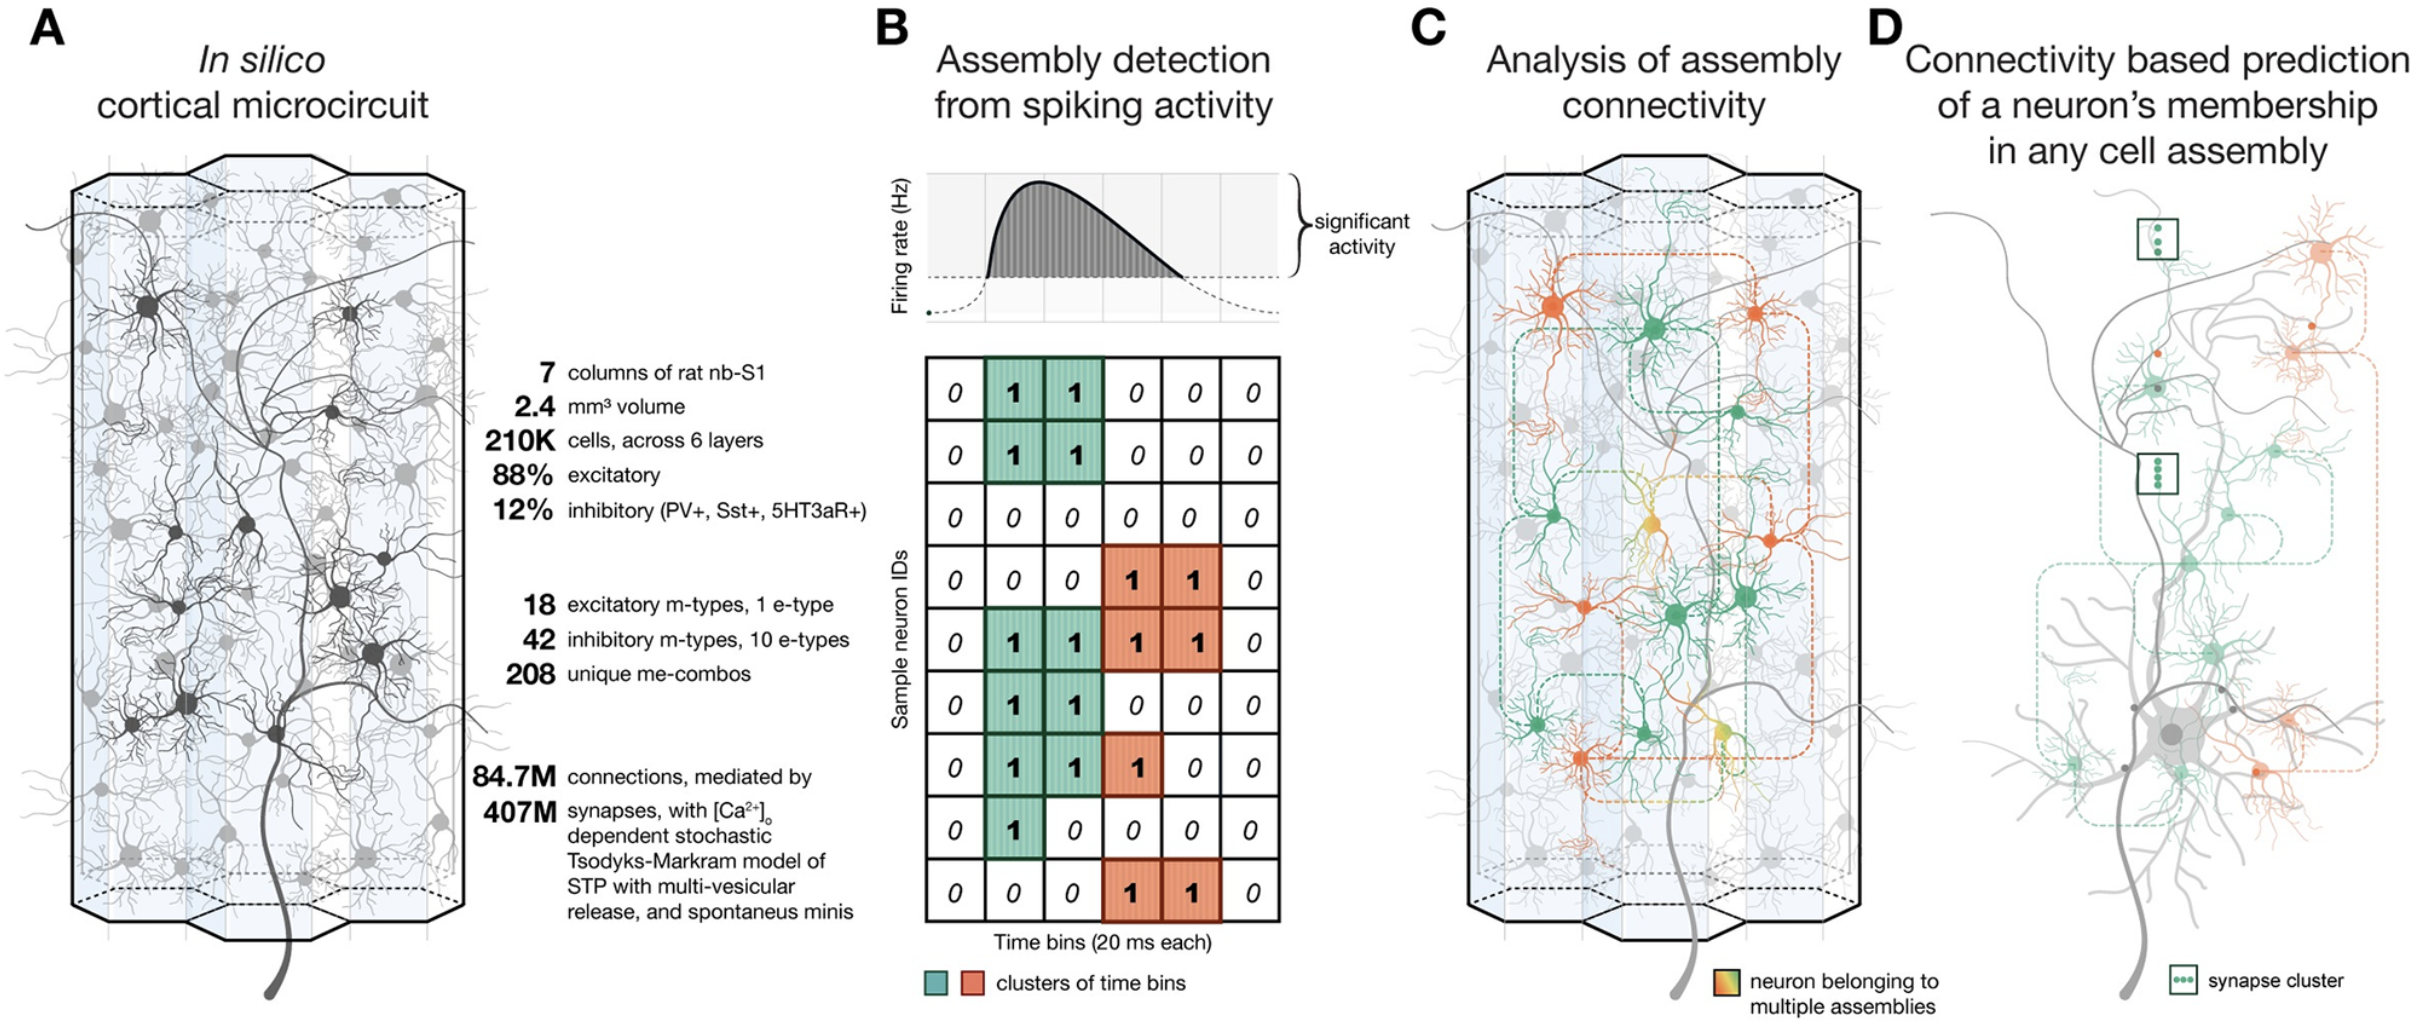

### What we will do
We will load the spiking data and the connectome of the model, calculate pairwise correlations, and relate the correlations to the connectivity.

In [ ]:
!pip install numpy
!pip install pandas
!pip install Connectome-Utilities
!pip install connectome-analysis
!pip install scipy

In [1]:
import numpy
import pandas
import conntility
import connalysis
import h5py

from scipy import sparse
from matplotlib import pyplot as plt

## Loading the data

First, we load the connectome of the model.
If you are using the stripped-down input file, this is the connectivity of only a small portion of the model (13k neurons).
This is in order to ensure the analysis run quickly. Feel free to try and get the full version to work!

Next, we read the spiking activity. The activity is represented as the time-binned activity in three separate datasets:
1. a T x N matrix, where T indicates the number of 20-ms time bins and N the number of neurons. 
    The entry at index [i, j] is the number of spikes of neuron j in time bin i. We call this the "spiking matrix".
2. An array of length N that holds global identifiers ("gids") of each neuron. In the same order as the second dimension of the spiking matrix.
3. An array of length T that holds the start points in ms of each time bin in the spiking matrix.

Note that time bins with non-significant spiking (i.e., at background levels) and non-spiking neurons are omitted to keep the data size small!

In [ ]:
# Path to the "assemblies.h5" file. Obtain from the link above.
# For a first run, use the stripped-down version.
# Later on, you can try to use the full version instead!
fn = "assemblies.h5"

# First, we load the connectome of the model.
S = conntility.ConnectivityMatrix.from_h5(fn, "full_matrix")

# Load spiking data
h5 = h5py.File(fn, "r")
# Spike matrix
m = h5["spikes"]["seed1"]["spike_matrix"][:]
# Lookup of global identifiers
gids = h5["spikes"]["seed1"]["gids"][:]
# Lookup of time bins
t = h5["spikes"]["seed1"]["t_bins"][:]

print(m.shape) # Number of neurons X number of significant time bins

(133287, 1377)


## A quick look into the loaded connectome

To get a feeling for the data, we take a quick look into the connectome.

We plot the locations of the neurons loaded, and count the number of connections.

,node_ids,layer,mtype,x,y,z,ss_flat_x,depth,ss_flat_y
0,473,3,L3_TPC:A,4256.445983,-1436.201655,-1996.809993,1288.406448,455.683417,2430.689343
1,503,3,L3_TPC:A,4375.797338,-1368.977633,-2091.973131,1489.604188,409.931437,2400.406694
2,538,3,L3_TPC:A,4158.050846,-1219.555411,-2132.907011,1442.709902,599.637704,2564.953602
3,539,3,L3_TPC:A,4263.278646,-1314.121022,-1869.102500,1290.920548,336.419353,2584.667663
4,550,3,L3_TPC:A,4038.532237,-1240.903074,-2012.185561,1284.232718,625.882715,2627.899297



Loaded 13348 neurons with 2603526 connections!



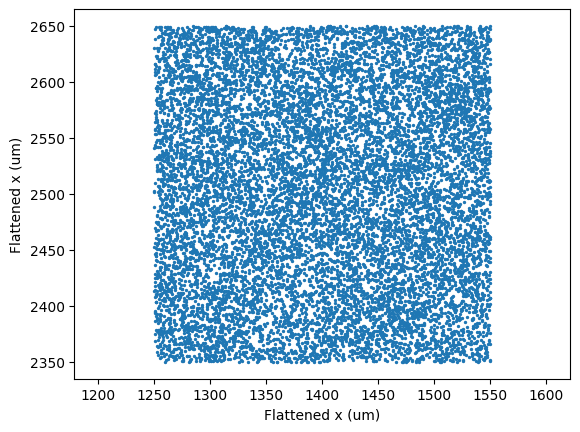

In [3]:
# Each neuron is a "vertex" in the graph view of a connectome. 
# We access the properties of the neurons as a pandas Dataframe using the .vertices function.
display(S.vertices.head())

# We plot the locations of the loaded neurons in a "flat" coordinate system where the axes are parallel to the layer boundaries.
# If you loaded the stripped-down version, this will cover only 300 x 300 um. The full version is larger. 
plt.scatter(S.vertices["ss_flat_x"], S.vertices["ss_flat_y"], s=2)
plt.gca().set_xlabel("Flattened x (um)")
plt.gca().set_ylabel("Flattened x (um)")
plt.axis("equal")

print("""
Loaded {0} neurons with {1} connections!
""".format(len(S), len(S.edges)))

## Counting simplices and edge participation

We analyze connectivity in terms of "directed simplices". These are highly significant motifs that are overexpressed in biological networks. The concept of a simplex can be generalized to any size.

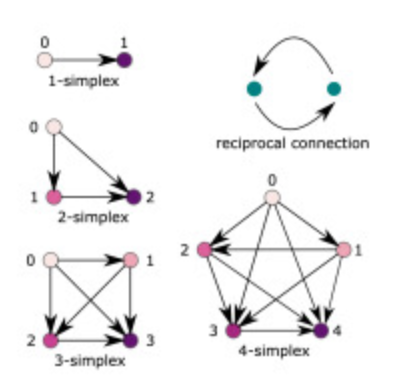

For each edge (i.e., synaptic connection) in a connectome, we can ask: How many such simplices of size X does it participate in? This is a combinatorically difficult question, so I will not go into the algorithmic details of how to do so efficiently.

Here, we simply use the "edge_participation" function of the "connalysis" package.

In [4]:
EP = connalysis.network.topology.edge_participation(S.matrix)

display(EP.head())

[2025-04-04 16:48:56,578] INFO: Done running flagser


,0,1,2,3,4,5,6
"(0, 49)",0,1,27,39,5,0,0
"(0, 141)",0,1,18,11,0,0,0
"(0, 208)",0,1,24,30,3,0,0
"(0, 231)",0,1,29,33,3,0,0
"(0, 258)",0,1,18,14,2,0,0


The output is a DataFrame. The index (vertical axis) is a tuple that describes the indices of the pre- and post-synaptic neurons. Each column denotes a possible size of a simplex (0 indicates 1 neuron. 1 indicates 2 neurons, i.e. an edge. Etc.)

The values then indicate how many simplices of a given size an edge participates in.

### Adding simplex participation information to the loaded connectome

For convenience, we add the simplex participation as properties associated with the edges of the connectome. To do so, we have to ensure that the order of the DataFrame matches the order of the edges in the connectome. Then, we can add the information in a single function call

In [5]:
# Access the order of the edges in "S", the loaded connectome
edge_indices = S._edge_indices.apply(tuple, axis=1)
# Re-order the contents of "EP" (edge participation) to match that order.
EP = EP.loc[edge_indices.values]

# Each column corresponds to one simplex size. We iterate over them
for col in EP.columns:
    # Sizes 0 and 1 (i.e., 1 neuron and 2 neurons) are not informative. Can you explain why?
    if int(col) > 1:
        S.add_edge_property("Dim. {0} participation".format(col),
                            EP[col].values)

## A quick look into the loaded spiking data

To get a feeling for the data, we take a quick look at the spiking data.

As the spikes are already binned, it is simple to generate a raster plot of a subset of neurons.

Text(0, 0.5, 'Neuron')

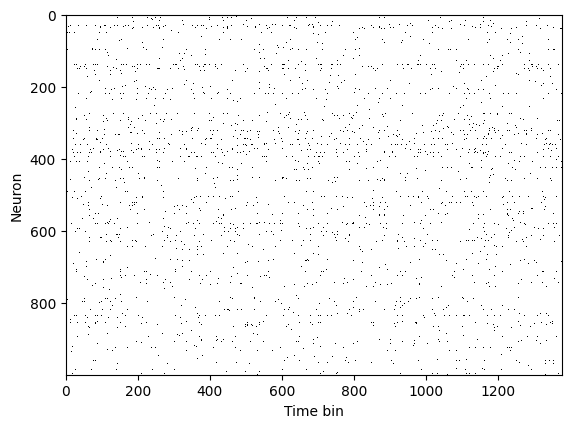

In [10]:
# Plotting all neurons would make it difficult to see any kind of structure.
# So we plot 1000 "randomly" chosen neurons. Feel free to explore further.
plt.imshow(m[5000:6000], cmap="Greys", interpolation="nearest")
plt.gca().set_xlabel("Time bin"); plt.gca().set_ylabel("Neuron")

## Aligning structure and function.

Now we have to solve a small problem. 

In the stripped down data, only 13k out of 221k neurons are contained in the connectome. Thus, not all neurons in the spiking data are represented in the connectome. 

At the same time, a small fracton of non-spiking neurons is not contained in the spiking data. Thus, not all neurons in the connectome are represented in the spiking data.

Here, we calculate the overlap of represented neurons and align the data into the same order.

In [6]:
# "gids" or neurons that are in both connectome and spiking data
intersecting_ids = numpy.intersect1d(gids, S.gids)
# On the connectome, we restric to the "subpopulation" of the intersecting ids.
S = S.subpopulation(intersecting_ids)

# The rows of the spiking matrix are in the order given by the "gids" array.
# We calculate a lookup series from "gids" to row indices of the spiking matrix.
gid_lookup = pandas.Series(gids, name="gids").reset_index().set_index("gids")["index"]
# That is, the neuron with the global identifier 12345 is in row gid_lookup[12345] of the spike matrix.

# We look up the indices that will give us the same order as the neurons in the loaded connectome.
_idxx = gid_lookup[S.gids].values

# Re-order rows of the spiking matrix and drop rows that are not represented in the loaded connectome
m_aligned_w_S = m[_idxx]

## Correlations as the cosine similarity of binned spikes

We calculate the correlations of pairs of neurons as the cosine similarity of their binned spiking data.
This can be done efficiently as the normalized dot product of the spiking matrix.

In [7]:
def cosine_similarity(m_in):
    """
    Calculates the cosine similarity of the data in m_in.
    Args: m_in (numpy.array)
    Assumes that each row corresponds to an individual and each column to an observation
    """
    # Dot product as raw similarity
    CC = numpy.dot(m_in, m_in.transpose())
    v_norm = numpy.linalg.norm(m_in, axis=1)
    nrmlz = v_norm.reshape((-1, 1)) * v_norm.reshape((1, -1))
    # Normalize with the product of the lengths of the vectors in pairs of rows.
    #nrmlz = numpy.sqrt(numpy.diag(CC).reshape((-1, 1)) * numpy.diag(CC).reshape((1, -1)))
    CC_nrmlz = CC / nrmlz
    return CC_nrmlz

CC_nrmlz = cosine_similarity(m_aligned_w_S)

/var/folders/py/wqmt8l2s5zb8fhrxbd_b258w0000gn/T/ipykernel_7693/1220152280.py:13: RuntimeWarning: invalid value encountered in divide
  CC_nrmlz = CC / nrmlz


We also add the spiking correlations of connected pairs of neurons as an edge property to the connectome.

In [8]:
S.add_edge_property("CC", CC_nrmlz[S._edge_indices["row"], S._edge_indices["col"]])

## Plot results

We plot edge participation against mean correlation. Separately for simplices of all encountered sizes.

Since we added the data as edge properties to the connectome, this can be done quickly using pandas .groupby functionality

Text(0, 0.5, 'Mean correlation')

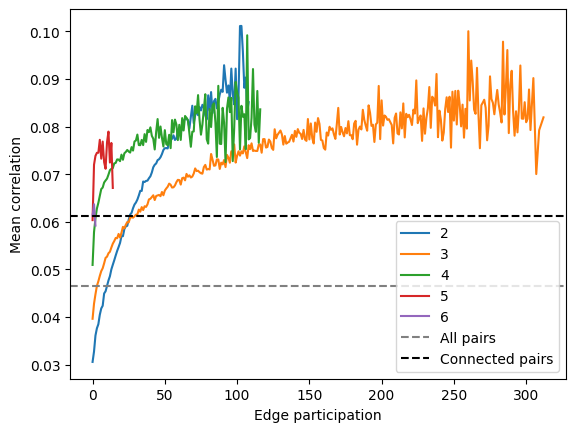

In [18]:
# Only consider mean correlations where more than this number of pairs have been found.
# Lower values lead to noisier results.
min_counts = 100

overall_mean_cc_all = numpy.nanmean(CC_nrmlz)
overall_mean_cc_connected = S.edges["CC"].mean()

for dim in [2, 3, 4, 5, 6]:
    mn_cc = S.edges.groupby("Dim. {0} participation".format(dim))["CC"].mean()
    counts = S.edges.groupby("Dim. {0} participation".format(dim))["CC"].count()
    mn_cc = mn_cc[counts > min_counts].sort_index()
    plt.plot(mn_cc, label=dim)

plt.gca().set_xlim(plt.gca().get_xlim())
plt.plot(plt.gca().get_xlim(), [overall_mean_cc_all, overall_mean_cc_all],
    color="grey", ls="--", label="All pairs")   
plt.plot(plt.gca().get_xlim(), [overall_mean_cc_connected, overall_mean_cc_connected],
    color="black", ls="--", label="Connected pairs")   

plt.legend()
plt.gca().set_xlabel("Edge participation")
plt.gca().set_ylabel("Mean correlation")